In [1]:
from dotenv import load_dotenv

load_dotenv()


True

#### Multi Agente Supervisor

In [2]:
import os
from typing import Annotated, Literal

import requests
from langchain_anthropic import ChatAnthropic  # noqa
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command

Documentación

[ReAct: Synergizing Reasoning and Acting in Language Models](https://react-lm.github.io/)


In [3]:
@tool
def get_weather(city: Annotated[str, "Ciudad que se quiere consultar"]):
    """Tool que obtiene el clima de una ciudad"""

    WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")

    resp = requests.get(
        f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{city}/today?unitGroup=metric&include=current&key={WEATHER_API_KEY}&contentType=json"
    )

    return resp.json()


tavily_tool = TavilySearchResults(max_results=3)

In [4]:
members = ["researcher", "weather_specialist"]

options = members + ["FINISH"]

system_prompt = f"""
            Eres un supervisor encargado de gestionar una conversación entre los siguientes workers: {members}. 
            Dada la siguiente solicitud del usuario, responde indicando qué worker debe actuar a continuación. 
            Cada worker realizará una tarea y responderá con sus resultados y estado.
            Cualquier consulta sobre el clima usa el worker weather_specialist.   
            Cuando todos hayan terminado responde con FINISH.  
            """

In [5]:
# model = ChatAnthropic(model_name="claude-3-haiku-20240307")
model = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [6]:
class Router(TypedDict):
    """Dirige a los workers al siguiente paso. Si no se necesitan workers, se redirige a FINISH."""

    next: Literal[*options]  # type: ignore


class State(MessagesState):
    next: str

In [7]:
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:  # type: ignore
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = model.with_structured_output(Router).invoke(messages)

    goto = response["next"]

    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})


# create_react_agent: crea un agente usando la técnica de ReAct prompting
research_agent = create_react_agent(model, tools=[tavily_tool])


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# create_react_agent: crea un agente usando la técnica de ReAct prompting
weather_specialist_agent = create_react_agent(model, tools=[get_weather])


def weather_specialist_node(state: State) -> Command[Literal["supervisor"]]:
    result = weather_specialist_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="weather_specialist"
                )
            ]
        },
        goto="supervisor",
    )

In [8]:
workflow = StateGraph(State)

workflow.add_edge(START, "supervisor")

workflow.add_node("supervisor", supervisor_node)
workflow.add_node("researcher", research_node)
workflow.add_node("weather_specialist", weather_specialist_node)

graph = workflow.compile()

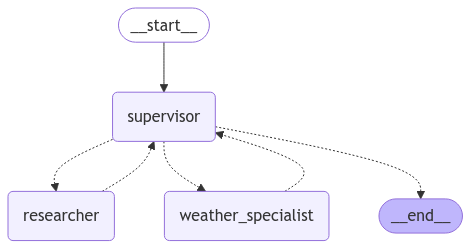

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Prueba

In [12]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Genera un resumen de las principales noticias de hoy en chile y ademas la temperatura actual en santiago de chile (primero busca la temperatura)",
            )
        ]
    },
    {"recursion_limit": 25}
):
    print(s)
    print("----")


{'supervisor': {'next': 'weather_specialist'}}
----
{'weather_specialist': {'messages': [HumanMessage(content='De acuerdo a los datos obtenidos, en Santiago de Chile la temperatura actual es de 25.4°C con cielo despejado (Clear). La sensación térmica también es de 25.4°C y hay una humedad del 36.8%.\n\nLamento informarte que no tengo una herramienta disponible para obtener las noticias actuales de Chile. Para obtener un resumen de las principales noticias, te recomendaría:\n\n1. Consultar directamente los principales medios de comunicación chilenos\n2. Visitar sitios web de noticias oficiales\n3. Consultar las redes sociales de los principales medios informativos del país\n\n¿Te gustaría que te ayude a encontrar algunas fuentes confiables de noticias chilenas?', additional_kwargs={}, response_metadata={}, name='weather_specialist', id='54b1cfa9-4c9f-47af-a794-2278e999c70b')]}}
----
{'supervisor': {'next': 'researcher'}}
----
{'researcher': {'messages': [HumanMessage(content='De acuerdo